In [5]:
from pathlib import Path
import joblib
import numpy as np
import pandas as pd

data_dir = Path("/data/processed")

X_full = joblib.load(data_dir / "X_full.joblib")
y_full = joblib.load(data_dir / "y_full.joblib")

print("Type X_full :", type(X_full))
print("Shape X_full:", X_full.shape)
print("Shape y_full:", np.array(y_full).shape)

if isinstance(X_full, pd.DataFrame):
    feature_names = X_full.columns
else:
    feature_names = pd.read_csv(
        "D:/Dataset/features.txt",
        delim_whitespace=True, header=None, names=["idx", "name"]
    )["name"].values
    X_full = pd.DataFrame(X_full, columns=feature_names)

activity_labels_df = pd.read_csv(
    "D:/Projet_ML/MLFLOW_HumanActivity/data/raw/UCI HAR Dataset/activity_labels.txt",
    sep=r"\s+", header=None, names=["id", "label"]
)
activity_labels = dict(zip(activity_labels_df["id"], activity_labels_df["label"]))

print("Colonnes X_full (extrait) :", feature_names[:5])


Type X_full : <class 'pandas.core.frame.DataFrame'>
Shape X_full: (10299, 561)
Shape y_full: (10299,)
Colonnes X_full (extrait) : Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y'],
      dtype='object')


In [6]:
from joblib import load

scaler_path = Path("/models/scaler.joblib")
model_path = Path("/models/best_model.joblib")

scaler = load(scaler_path)
best_model = load(model_path)

print("Scaler et modèle chargés.")
print("Type du modèle :", type(best_model))


Scaler et modèle chargés.
Type du modèle : <class 'sklearn.pipeline.Pipeline'>


In [7]:
X = X_full.values
y = np.array(y_full)

X_scaled = scaler.transform(X)

print("X_scaled shape :", X_scaled.shape)

n_background = min(2000, X_scaled.shape[0])
X_background = X_scaled[:n_background]

n_test_explain = min(500, X_scaled.shape[0])
X_explain = X_scaled[:n_test_explain]
y_explain = y[:n_test_explain]

print("Background pour SHAP :", X_background.shape)
print("Échantillon expliqué :", X_explain.shape)


X_scaled shape : (10299, 561)
Background pour SHAP : (2000, 561)
Échantillon expliqué : (500, 561)


d:\Projet_ML\MLFLOW_HumanActivity\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


d:\Projet_ML\MLFLOW_HumanActivity\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Type du modèle : <class 'sklearn.pipeline.Pipeline'>
Utilisation directe de KernelExplainer (modèle SVC)
 Explainer créé, calcul des SHAP values...


  0%|          | 0/10 [00:00<?, ?it/s]d:\Projet_ML\MLFLOW_HumanActivity\.venv\Lib\site-packages\shap\explainers\_kernel.py:708: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(
d:\Projet_ML\MLFLOW_HumanActivity\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=9.748e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
d:\Projet_ML\MLFLOW_HumanActivity\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.p

 SHAP values calculées. Shapes :
Shape shap_values : (10, 561, 6)


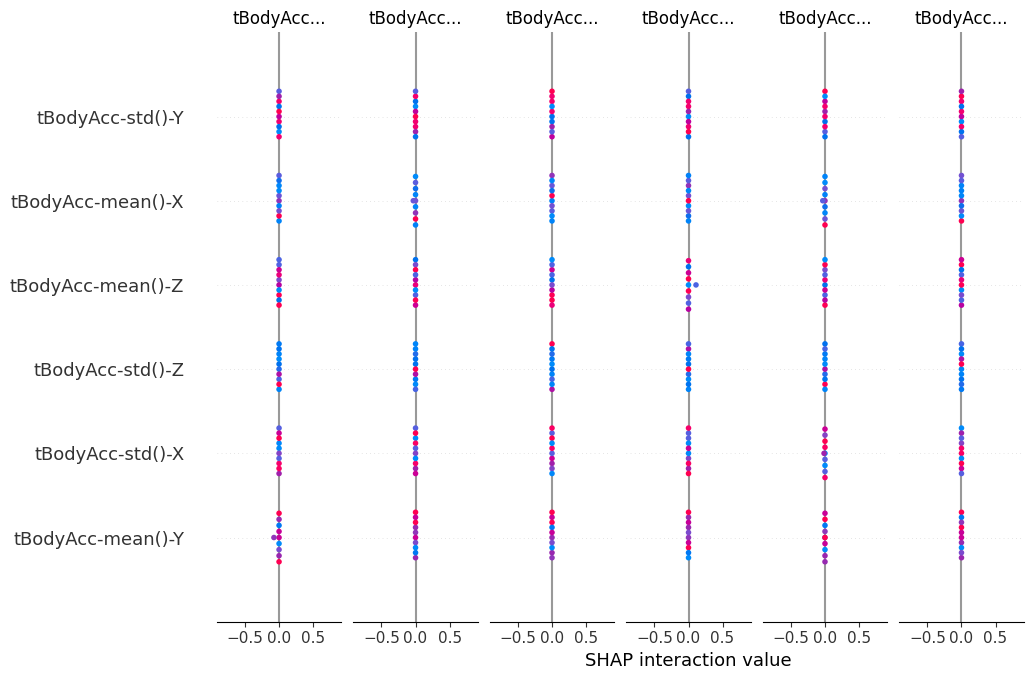

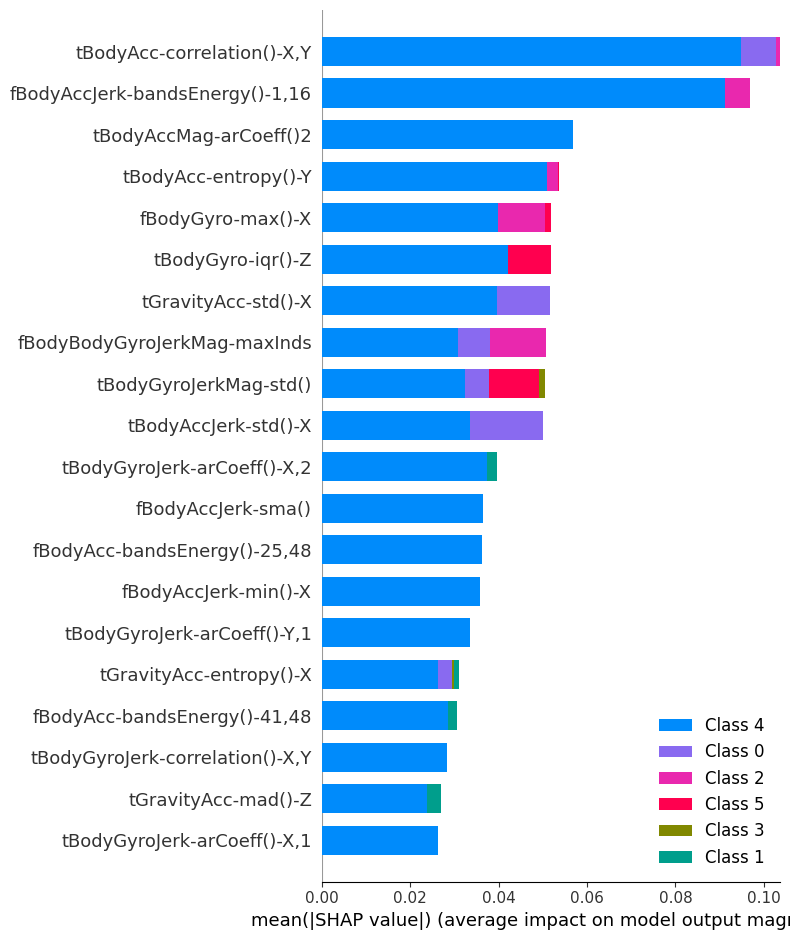

In [8]:
import shap
import matplotlib.pyplot as plt

shap.initjs()

print("Type du modèle :", type(best_model))


print("Utilisation directe de KernelExplainer (modèle SVC)")


background_small = shap.sample(X_background, 30, random_state=42)


X_explain_small = X_explain[:10]
y_explain_small = y_explain[:10]

explainer = shap.KernelExplainer(
    best_model.predict_proba,
    background_small
)

print(" Explainer créé, calcul des SHAP values...")
shap_values = explainer.shap_values(X_explain_small, nsamples=100)

print(" SHAP values calculées. Shapes :")
if isinstance(shap_values, list):
    print("Nombre de classes :", len(shap_values))
    print("Shape d'une matrice SHAP :", shap_values[0].shape)
else:
    print("Shape shap_values :", shap_values.shape)

shap.summary_plot(shap_values, X_explain_small, feature_names=feature_names)
shap.summary_plot(shap_values, X_explain_small, feature_names=feature_names, plot_type="bar")


Vraie classe   : 5 - STANDING
Classe prédite : 5 - STANDING
Probas prédictes : {np.int64(1): np.float64(0.0), np.int64(2): np.float64(0.0), np.int64(3): np.float64(0.0), np.int64(4): np.float64(0.016), np.int64(5): np.float64(0.983), np.int64(6): np.float64(0.0)}
Shape des SHAP values pour l'instance : (561,)


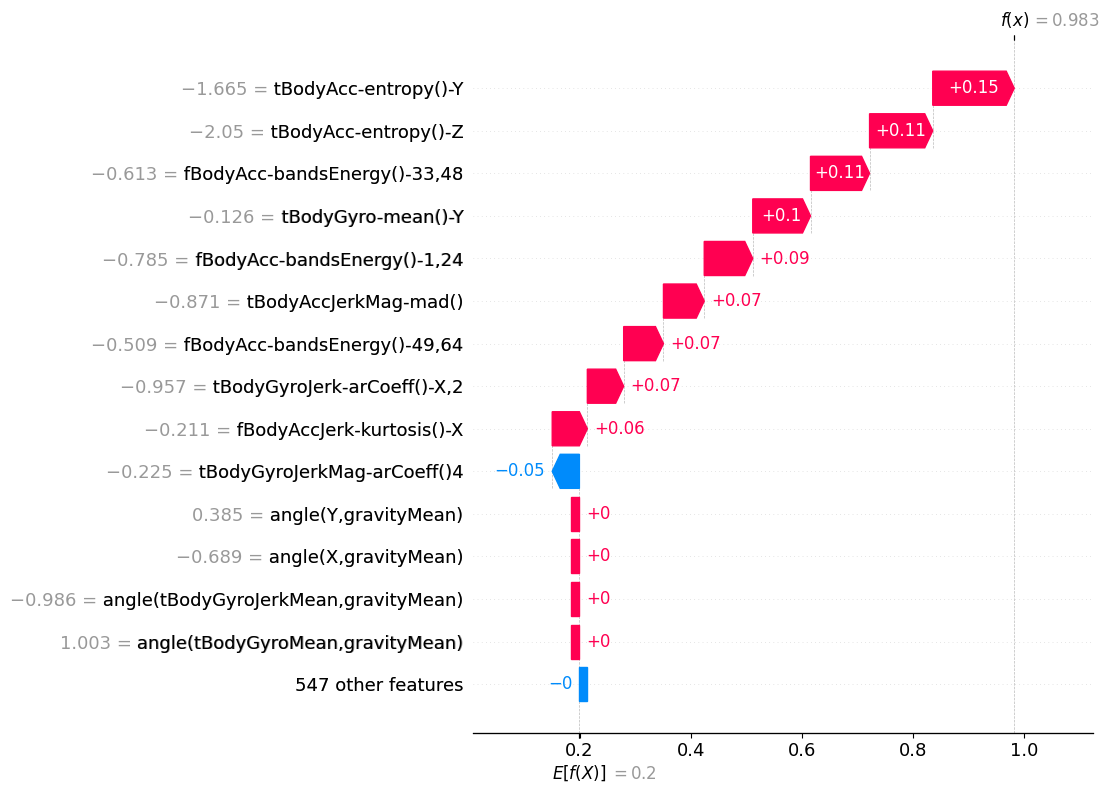

In [9]:
import shap
import numpy as np


i = 3  


true_label = int(y_explain_small[i])
print("Vraie classe   :", true_label, "-", activity_labels.get(true_label, "Unknown"))

proba = best_model.predict_proba(X_explain_small[i].reshape(1, -1))[0]
class_ids = best_model.classes_         
pred_class_idx = int(np.argmax(proba))     
pred_class_label = int(class_ids[pred_class_idx])

print("Classe prédite :", pred_class_label, "-", activity_labels.get(pred_class_label, "Unknown"))
print("Probas prédictes :", dict(zip(class_ids, np.round(proba, 3))))


if isinstance(shap_values, list):

    sv_i = shap_values[pred_class_idx][i]         
    base_value = explainer.expected_value[pred_class_idx]
else:
   
    sv_i = shap_values[i]                          

    if sv_i.ndim == 2:
       
        sv_i = sv_i[:, pred_class_idx]

    base_value = explainer.expected_value

    if np.ndim(base_value) > 0:
        base_value = base_value[pred_class_idx]


print("Shape des SHAP values pour l'instance :", sv_i.shape)


expl = shap.Explanation(
    values=sv_i,                          
    base_values=base_value,
    data=X_explain_small[i],
    feature_names=feature_names
)

shap.plots.waterfall(expl, max_display=15)


In [10]:
import numpy as np
import pandas as pd


print("X_explain_small shape :", X_explain_small.shape)
print("len(y_explain_small)  :", len(y_explain_small))

class_ids = best_model.classes_  

rows = []

for i in range(X_explain_small.shape[0]):

    true_label = int(y_explain_small[i])
    proba = best_model.predict_proba(X_explain_small[i].reshape(1, -1))[0]
    pred_class_idx = int(np.argmax(proba))         
    pred_label = int(class_ids[pred_class_idx])    

   
    if isinstance(shap_values, list):
      
        sv_i = shap_values[pred_class_idx][i]     
    else:
   
        sv_i = shap_values[i]
        if sv_i.ndim == 2:                         
            sv_i = sv_i[:, pred_class_idx]       


    abs_sv = np.abs(sv_i)
    top_idx = np.argsort(-abs_sv)[:10]          

    for rank, j in enumerate(top_idx, start=1):
        rows.append({
            "sample_local_index": i,
            "true_label": true_label,
            "true_label_name": activity_labels.get(true_label, "Unknown"),
            "pred_label": pred_label,
            "pred_label_name": activity_labels.get(pred_label, "Unknown"),
            "feature_rank": rank,
            "feature_index": int(j),
            "feature_name": feature_names[j],
            "feature_value": float(X_explain_small[i, j]),
            "shap_value": float(sv_i[j]),
            "abs_shap": float(abs_sv[j]),
        })

df_top10 = pd.DataFrame(rows)

print("Nombre de lignes dans le top10 :", df_top10.shape[0])
df_top10.head(30)


X_explain_small shape : (10, 561)
len(y_explain_small)  : 10
Nombre de lignes dans le top10 : 100


sample_local_index  true_label true_label_name  pred_label  \
0                    0           5        STANDING           5   
1                    0           5        STANDING           5   
2                    0           5        STANDING           5   
3                    0           5        STANDING           5   
4                    0           5        STANDING           5   
5                    0           5        STANDING           5   
6                    0           5        STANDING           5   
7                    0           5        STANDING           5   
8                    0           5        STANDING           5   
9                    0           5        STANDING           5   
10                   1           5        STANDING           5   
11                   1           5        STANDING           5   
12                   1           5        STANDING           5   
13                   1           5        STANDING           5   
14                   1           5        STANDING           5   
15                   1           5        STANDING           5   
16                   1           5        STANDING           5   
17                   1           5        STANDING           5   
18                   1           5        STANDING           5   
19                   1           5        STANDING           5   
20                   2           5        STANDING           5   
21                   2           5        STANDING           5   
22                   2           5        STANDING           5   
23                   2           5        STANDING           5   
24                   2           5        STANDING           5   
25                   2           5        STANDING           5   
26                   2           5        STANDING           5   
27                   2           5        STANDING           5   
28                   2           5        STANDING           5   
29                   2           5        STANDING           5   

   pred_label_name  feature_rank  feature_index  \
0         STANDING             1            197   
1         STANDING             2            337   
2         STANDING             3             13   
3         STANDING             4            493   
4         STANDING             5             71   
5         STANDING             6            421   
6         STANDING             7             50   
7         STANDING             8            225   
8         STANDING             9            516   
9         STANDING            10            559   
10        STANDING             1            444   
11        STANDING             2            343   
12        STANDING             3            376   
13        STANDING             4            258   
14        STANDING             5             65   
15        STANDING             6             41   
16        STANDING             7             50   
17        STANDING             8            256   
18        STANDING             9             53   
19        STANDING            10            431   
20        STANDING             1             23   
21        STANDING             2            356   
22        STANDING             3            253   
23        STANDING             4            297   
24        STANDING             5            443   
25        STANDING             6            327   
26        STANDING             7            480   
27        STANDING             8             77   
28        STANDING             9            559   
29        STANDING            10            558   

                       feature_name  feature_value  shap_value  abs_shap  
0   tBodyGyroJerk-correlation()-X,Y      -0.607952    0.283974  0.283974  
1      fBodyAcc-bandsEnergy()-57,64      -0.329804    0.230316  0.230316  
2                  tBodyAcc-min()-Y       0.873499    0.194318  0.194318  
3     fBodyGyro-bandsEnergy()-41,48      -0.488625    0.165025  0.165025  


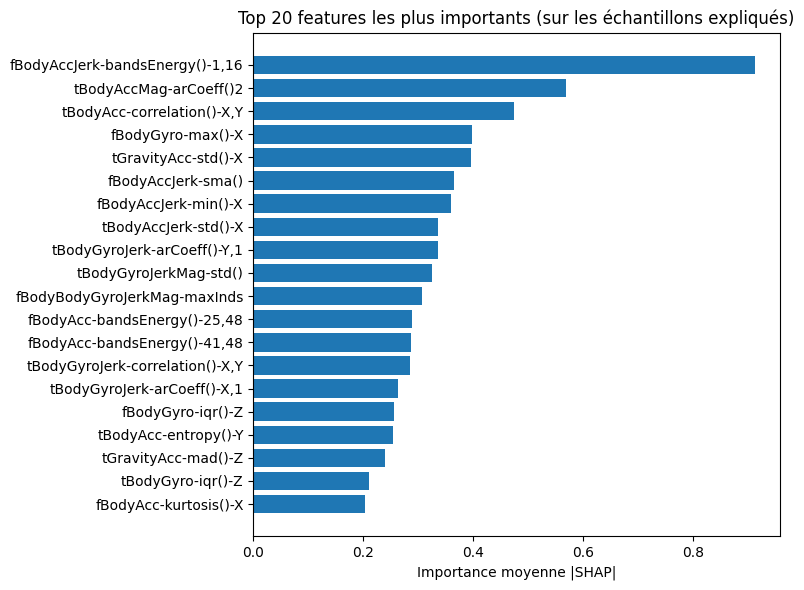

In [11]:
import matplotlib.pyplot as plt


feat_global = (
    df_top10
    .groupby("feature_name")["abs_shap"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

top_n = 20  
top_feat_global = feat_global.head(top_n)

plt.figure(figsize=(8, 6))
plt.barh(top_feat_global["feature_name"], top_feat_global["abs_shap"])
plt.gca().invert_yaxis()
plt.xlabel("Importance moyenne |SHAP|")
plt.title(f"Top {top_n} features les plus importants (sur les échantillons expliqués)")
plt.tight_layout()
plt.show()


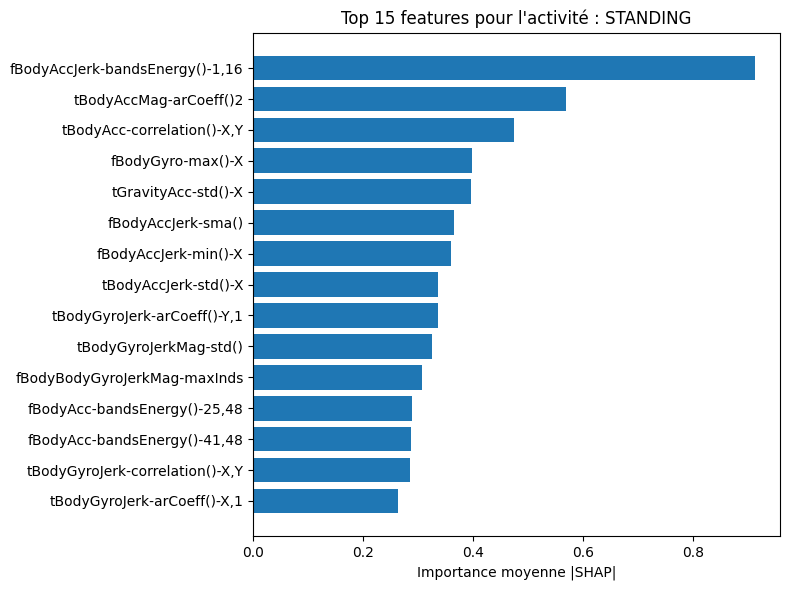

In [12]:
def plot_top_features_for_activity(activity_name, top_n=15):
   
    subset = df_top10[df_top10["true_label_name"] == activity_name]
    if subset.empty:
        print(f"Aucun échantillon avec true_label_name = {activity_name} dans df_top10.")
        return

    feat_act = (
        subset
        .groupby("feature_name")["abs_shap"]
        .mean()
        .sort_values(ascending=False)
        .reset_index()
        .head(top_n)
    )

    plt.figure(figsize=(8, 6))
    plt.barh(feat_act["feature_name"], feat_act["abs_shap"])
    plt.gca().invert_yaxis()
    plt.xlabel("Importance moyenne |SHAP|")
    plt.title(f"Top {top_n} features pour l'activité : {activity_name}")
    plt.tight_layout()
    plt.show()


plot_top_features_for_activity("STANDING", top_n=15)


Exemple de feature : fBodyAccJerk-bandsEnergy()-1,16


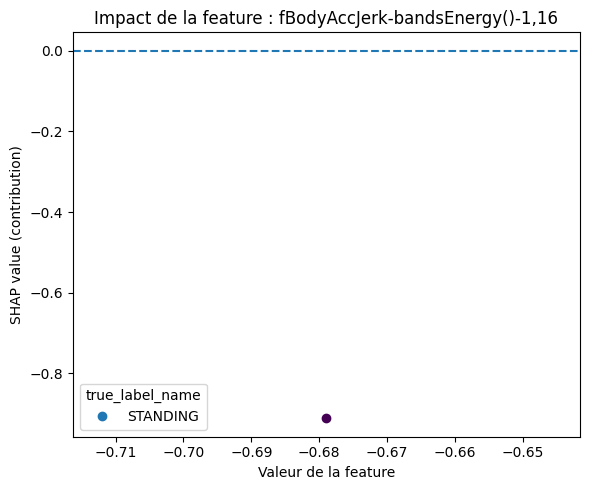

In [13]:
def plot_feature_scatter(feature_name):
    subset = df_top10[df_top10["feature_name"] == feature_name]
    if subset.empty:
        print(f"Aucune ligne pour la feature {feature_name} dans df_top10.")
        return

    plt.figure(figsize=(6, 5))

    activities = subset["true_label_name"].astype(str).values
    unique_acts = sorted(subset["true_label_name"].unique())


    act_to_idx = {act: idx for idx, act in enumerate(unique_acts)}
    colors = [act_to_idx[a] for a in activities]

    scatter = plt.scatter(
        subset["feature_value"],
        subset["shap_value"],
        c=colors
    )
    plt.axhline(0, linestyle="--")
    plt.xlabel("Valeur de la feature")
    plt.ylabel("SHAP value (contribution)")
    plt.title(f"Impact de la feature : {feature_name}")


    handles = [
        plt.Line2D([0], [0], marker="o", linestyle="", label=act)
        for act in unique_acts
    ]
    plt.legend(handles=handles, title="true_label_name")
    plt.tight_layout()
    plt.show()


some_feature = feat_global.iloc[0]["feature_name"]
print("Exemple de feature :", some_feature)
plot_feature_scatter(some_feature)


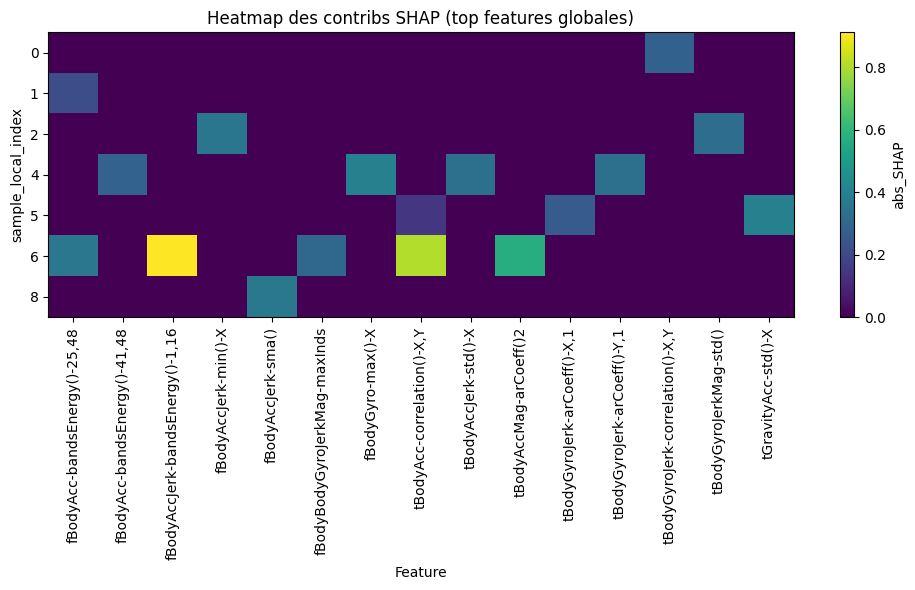

In [14]:

top_feats = (
    df_top10
    .groupby("feature_name")["abs_shap"]
    .mean()
    .sort_values(ascending=False)
    .head(15)              
    .index
)


pivot_df = (
    df_top10[df_top10["feature_name"].isin(top_feats)]
    .pivot_table(
        index="sample_local_index",
        columns="feature_name",
        values="abs_shap",
        aggfunc="max"  
    )
    .fillna(0)
)

plt.figure(figsize=(10, 6))
plt.imshow(pivot_df.values, aspect="auto")
plt.colorbar(label="abs_SHAP")
plt.xticks(range(len(pivot_df.columns)), pivot_df.columns, rotation=90)
plt.yticks(range(len(pivot_df.index)), pivot_df.index)
plt.xlabel("Feature")
plt.ylabel("sample_local_index")
plt.title("Heatmap des contribs SHAP (top features globales)")
plt.tight_layout()
plt.show()


In [15]:
from lime import lime_tabular
from IPython.display import display, HTML

lime_explainer = lime_tabular.LimeTabularExplainer(
    X_scaled,
    feature_names=feature_names.tolist(),
    class_names=[activity_labels[i] for i in sorted(activity_labels.keys())],
    discretize_continuous=True,
    mode="classification"
)

i = 10  
exp = lime_explainer.explain_instance(
    X_scaled[i],
    best_model.predict_proba,
    num_features=10
)

html = exp.as_html()
display(HTML(html))


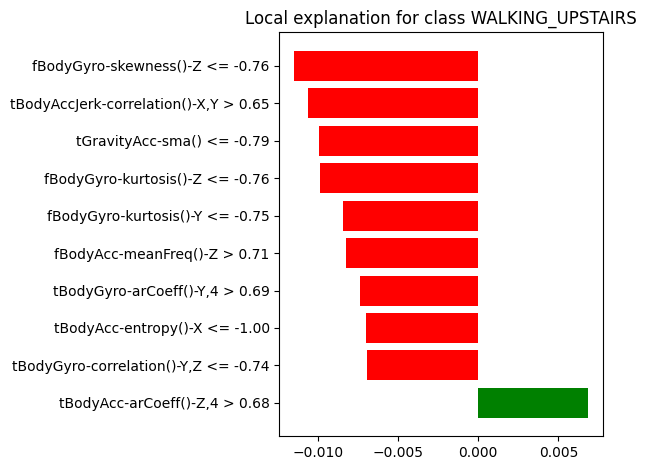

In [16]:
import matplotlib.pyplot as plt

fig = exp.as_pyplot_figure()
plt.tight_layout()
plt.show()


Vue graphique :


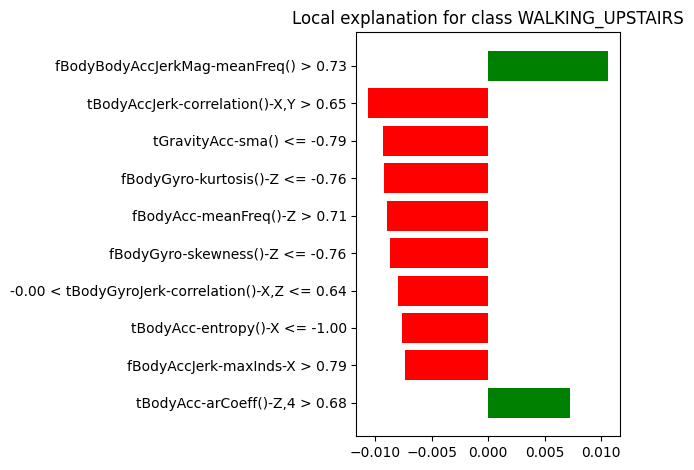


 Vue tableau :


In [17]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from lime import lime_tabular

lime_explainer = lime_tabular.LimeTabularExplainer(
    X_scaled,
    feature_names=feature_names.tolist(),
    class_names=[activity_labels[i] for i in sorted(activity_labels.keys())],
    discretize_continuous=True,
    mode="classification"
)

i = 10
exp = lime_explainer.explain_instance(
    X_scaled[i],
    best_model.predict_proba,
    num_features=10
)

print("Vue graphique :")
fig = exp.as_pyplot_figure()
plt.tight_layout()
plt.show()

print("\n Vue tableau :")
display(HTML(exp.as_html()))


 Sample index = 10
Vraie classe   : 5 - STANDING
Classe prédite : 5 - STANDING
Probas         : {np.int64(1): np.float64(0.0), np.int64(2): np.float64(0.0), np.int64(3): np.float64(0.0), np.int64(4): np.float64(0.008), np.int64(5): np.float64(0.992), np.int64(6): np.float64(0.0)}


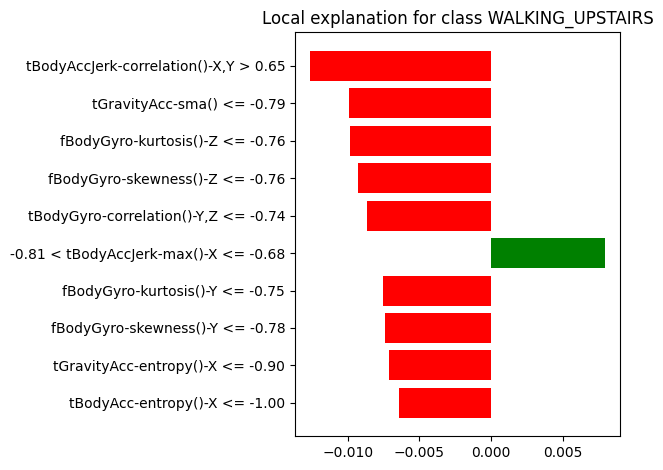

In [18]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt

def explain_with_lime(i, num_features=10):
    
    print(f" Sample index = {i}")
    true_label = int(y[i])
    proba = best_model.predict_proba(X_scaled[i].reshape(1, -1))[0]
    class_ids = best_model.classes_
    pred_class_idx = proba.argmax()
    pred_label = int(class_ids[pred_class_idx])

    print("Vraie classe   :", true_label, "-", activity_labels.get(true_label, "Unknown"))
    print("Classe prédite :", pred_label, "-", activity_labels.get(pred_label, "Unknown"))
    print("Probas         :", dict(zip(class_ids, proba.round(3))))

    exp = lime_explainer.explain_instance(
        X_scaled[i],
        best_model.predict_proba,
        num_features=num_features
    )


    fig = exp.as_pyplot_figure()
    plt.tight_layout()
    plt.show()


    display(HTML(exp.as_html()))


explain_with_lime(10)


In [19]:
import numpy as np
import pandas as pd

rows_lime = []
samples_per_class = 3   

class_ids = best_model.classes_  

for cls in class_ids:

    idxs = np.where(y == cls)[0]

    if len(idxs) == 0:
        continue  


    k = min(samples_per_class, len(idxs))
    chosen = np.random.choice(idxs, size=k, replace=False)

    for i in chosen:
        exp = lime_explainer.explain_instance(
            X_scaled[i],
            best_model.predict_proba,
            num_features=10
        )

        true_label = int(cls)
        proba = best_model.predict_proba(X_scaled[i].reshape(1, -1))[0]
        pred_class_idx = np.argmax(proba)
        pred_label = int(class_ids[pred_class_idx])

        for rank, (cond, weight) in enumerate(exp.as_list(), start=1):
            rows_lime.append({
                "sample_index": i,
                "true_label": true_label,
                "true_label_name": activity_labels.get(true_label, "Unknown"),
                "pred_label": pred_label,
                "pred_label_name": activity_labels.get(pred_label, "Unknown"),
                "feature_rank": rank,
                "feature_condition": cond,
                "lime_weight": float(weight),
            })

df_lime = pd.DataFrame(rows_lime)
df_lime["true_label_name"].value_counts()


true_label_name
WALKING               30
WALKING_UPSTAIRS      30
WALKING_DOWNSTAIRS    30
SITTING               30
STANDING              30
LAYING                30
Name: count, dtype: int64

In [20]:
feat_lime_global = (
    df_lime
    .groupby("feature_condition")["lime_weight"]
    .mean()
    .to_frame()
)

feat_lime_global["abs_weight"] = feat_lime_global["lime_weight"].abs()
feat_lime_global = feat_lime_global.sort_values("abs_weight", ascending=False)

feat_lime_global.head(20)


lime_weight  abs_weight
feature_condition                                                
fBodyGyro-kurtosis()-Z > 0.51                0.015816    0.015816
tBodyGyroJerk-correlation()-X,Z <= -0.64     0.013905    0.013905
tBodyAccJerk-correlation()-X,Y <= -0.67      0.013517    0.013517
tGravityAcc-entropy()-X > 0.76               0.013315    0.013315
tBodyGyroJerk-correlation()-X,Y <= -0.69     0.013100    0.013100
tBodyGyroJerk-correlation()-X,Y > 0.67      -0.012979    0.012979
tGravityAcc-sma() > 0.74                     0.012861    0.012861
fBodyGyro-kurtosis()-Y > 0.47                0.012604    0.012604
tBodyAccJerk-correlation()-X,Y > 0.65       -0.012604    0.012604
tBodyGyroJerk-correlation()-X,Z > 0.64      -0.012601    0.012601
fBodyGyro-skewness()-Z > 0.63                0.012491    0.012491
fBodyAcc-bandsEnergy()-1,8 > 0.60            0.011234    0.011234
tBodyAccJerk-min()-X <= -0.83                0.010585    0.010585
fBodyGyro-bandsEnergy()-1,24 > 0.46          0.010549    0.010549
tBodyAccJerkMag-iqr() > 0.84                -0.010461    0.010461
tBodyGyro-iqr()-Z > 0.78                     0.010278    0.010278
tGravityAcc-arCoeff()-Y,1 <= -0.68           0.010277    0.010277
fBodyGyro-maxInds-Z > 0.66                  -0.010260    0.010260
tBodyAccJerk-arCoeff()-Z,2 > 0.63           -0.010196    0.010196
fBodyGyro-skewness()-Y > 0.62                0.009776    0.009776

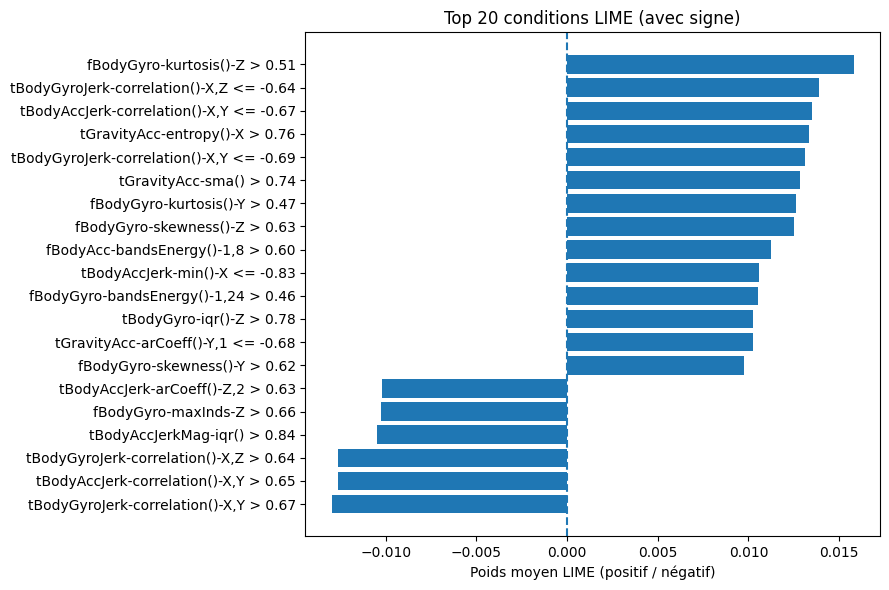

In [21]:
import matplotlib.pyplot as plt

feat_lime_signed = (
    df_lime
    .groupby("feature_condition")["lime_weight"]
    .mean()
    .sort_values(ascending=True)    
    .to_frame()
    .reset_index()
)

top_n = 20

feat_lime_signed["abs_weight"] = feat_lime_signed["lime_weight"].abs()
feat_lime_signed = feat_lime_signed.sort_values("abs_weight", ascending=False).head(top_n)
feat_lime_signed = feat_lime_signed.sort_values("lime_weight")  

plt.figure(figsize=(9, 6))
plt.barh(
    feat_lime_signed["feature_condition"],
    feat_lime_signed["lime_weight"]
)
plt.axvline(0, linestyle="--")
plt.xlabel("Poids moyen LIME (positif / négatif)")
plt.title(f"Top {top_n} conditions LIME (avec signe)")
plt.tight_layout()
plt.show()


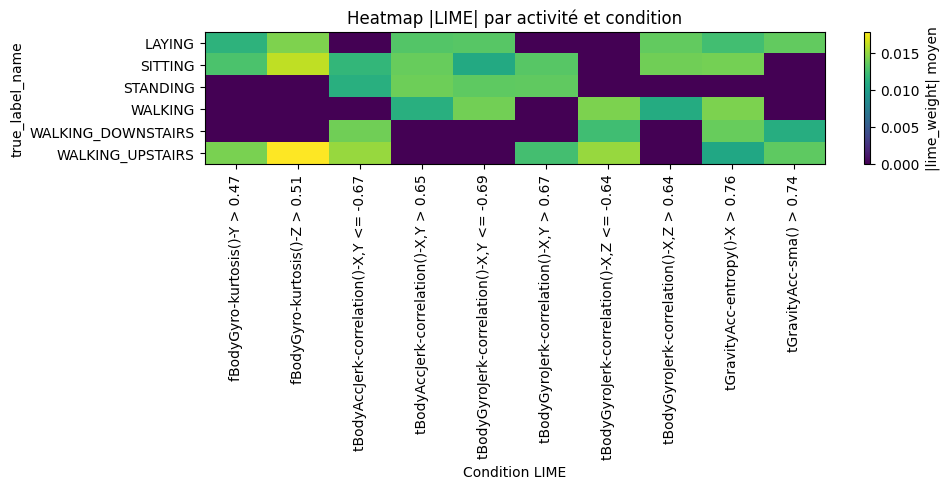

In [22]:

top_conditions = (
    feat_lime_global
    .sort_values("abs_weight", ascending=False)
    .head(10)
    .index
)


pivot_lime = (
    df_lime[df_lime["feature_condition"].isin(top_conditions)]
    .groupby(["true_label_name", "feature_condition"])["lime_weight"]
    .mean()
    .abs()
    .reset_index()
    .pivot(index="true_label_name", columns="feature_condition", values="lime_weight")
    .fillna(0)
)

plt.figure(figsize=(10, 5))
plt.imshow(pivot_lime.values, aspect="auto")
plt.colorbar(label="|lime_weight| moyen")
plt.xticks(range(len(pivot_lime.columns)), pivot_lime.columns, rotation=90)
plt.yticks(range(len(pivot_lime.index)), pivot_lime.index)
plt.xlabel("Condition LIME")
plt.ylabel("true_label_name")
plt.title("Heatmap |LIME| par activité et condition")
plt.tight_layout()
plt.show()
